[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana10/1_LSTM_para_prediccion.ipynb)

IMPORTANTE: Antes de iniciar es recomendable cambiar el entorno de ejecución a GPU

# Introducción

En esta clase utilizaremos una red neuronal recurrente para tratar de predecir el siguiente valor en una serie de tiempo. En clases pasadas utilizamos capas LSTM para un algoritmo de clasificación, mientras que en este caso será para predicción.

Utilizaremos una herramienta auxiliar conocida, el API de yahoo finance, para obtener series de tiempo para las predicciones.

# Dependencias e instalaciones

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 8.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM # Long Short Term Memory
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

import yfinance as yf

In [ ]:
data_raw = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "GOOG AAPL",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "10y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data_raw

[*********************100%***********************]  2 of 2 completed


,AAPL,GOOG
Date,,
2013-02-15,14.193984,19.748228
2013-02-19,14.188739,20.095926
2013-02-20,13.845118,19.737518
2013-02-21,13.759058,19.813982
2013-02-22,13.905575,19.918093
...,...,...
2023-02-08,151.688400,100.000000
2023-02-09,150.639999,95.459999
2023-02-10,151.009995,94.860001


In [ ]:
df_aux = data_raw[['GOOG']].copy()
df_aux

,GOOG
Date,
2013-02-15,19.748228
2013-02-19,20.095926
2013-02-20,19.737518
2013-02-21,19.813982
2013-02-22,19.918093
...,...
2023-02-08,100.000000
2023-02-09,95.459999
2023-02-10,94.860001


In [ ]:
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-02-15 to 2023-02-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    2517 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [ ]:
data = df_aux.copy()

# Paréntesis cultural: Fechas

In [ ]:
# Convertir string a tipo datetime
pd.to_datetime('2021-12-31')

Timestamp('2021-12-31 00:00:00')

In [ ]:
# Lee la fecha ocn formato de EUA
pd.to_datetime('02-12-2022')

Timestamp('2022-02-12 00:00:00')

In [ ]:
# Lee el primer elemento como el dia
pd.to_datetime('02-12-2022', dayfirst=True)

Timestamp('2022-12-02 00:00:00')

In [ ]:
# Deltas (o diferencias) de fechas
(pd.to_datetime('2021-12-31') - pd.to_datetime('2021-12-21'))

Timedelta('10 days 00:00:00')

In [ ]:
(pd.to_datetime('2021-12-31') - pd.to_datetime('2021-12-21')).days

10

# Fin de paréntesis cultural

In [ ]:
data_train = data.loc[:pd.to_datetime('2021-01-01'), :].to_numpy()
data_test = data.loc[pd.to_datetime('2021-01-01'):,:].to_numpy()

In [ ]:
print(data_train.shape)
print(data_test.shape)

(1984, 1)
(533, 1)


In [ ]:
data_train

array([[19.74822807],
       [20.09592628],
       [19.73751831],
       ...,
       [87.93599701],
       [86.97599792],
       [87.59400177]])

# Ejercicio:

Existe un modo de hacer la separación de train y test utilizando la función "train_test_split", prueben hacerlo utilizandola.

Lo importante es que no se tomen las muestras al azar, si no que mantengan el orden temporal (las primeras fechas para train y las posteriores para test)

In [ ]:
# Utilice train_test_split()

data_ejercicio = data.copy()


In [ ]:
train_ejercicio, test_ejercicio = train_test_split(data_ejercicio, train_size=.80, shuffle=False)

In [ ]:
test_ejercicio

,GOOG
Date,
2021-02-16,106.095001
2021-02-17,106.415497
2021-02-18,105.860001
2021-02-19,105.056999
2021-02-22,103.244003
...,...
2023-02-08,100.000000
2023-02-09,95.459999
2023-02-10,94.860001


In [ ]:
scaler = MinMaxScaler()

data_train = scaler.fit_transform(data_train.reshape(-1,1))
data_test = scaler.transform(data_test.reshape(-1,1))

In [ ]:
data_train

array([[0.00929134],
       [0.0140989 ],
       [0.00914326],
       ...,
       [0.95211082],
       [0.93883709],
       [0.94738212]])

In [ ]:
data_train.shape

(1984, 1)

In [ ]:
data_test.shape

(533, 1)

## Uso de método shift

In [ ]:
copia = data_raw[['GOOG']].copy()

In [ ]:
copia['1 espacio'] = copia.GOOG.shift(1)
copia['2 espacio'] = copia.GOOG.shift(2)
copia

,GOOG,1 espacio,2 espacio
Date,,,
2013-02-15,19.748228,NaN,NaN
2013-02-19,20.095926,19.748228,NaN
2013-02-20,19.737518,20.095926,19.748228
2013-02-21,19.813982,19.737518,20.095926
2013-02-22,19.918093,19.813982,19.737518
...,...,...,...
2023-02-08,100.000000,108.040001,103.470001
2023-02-09,95.459999,100.000000,108.040001
2023-02-10,94.860001,95.459999,100.000000


## Preprocesamiento de los datos

In [ ]:
def data_prep(data):
  x = []
  y = []

  for i in range(10,len(data)):
    x.append(data[i-10:i]) # Registra todos lo data_train en bloques de 10 dias
    y.append(data[i]) # Registra todos los data_train seguidos a partir del dia 10

  x = np.array(x)
  y = np.array(y)

  x = x.reshape(x.shape[0],x.shape[1],1)
  y = y.reshape(y.shape[0],1)
  return x,y

In [ ]:
x_train, y_train = data_prep(data_train)

In [ ]:
print(x_train)
print('----------')
print(y_train)
x_train.shape, y_train.shape

[[[0.00929134]
  [0.0140989 ]
  [0.00914326]
  ...
  [0.01166413]
  [0.01215313]
  [0.01387159]]

 [[0.0140989 ]
  [0.00914326]
  [0.01020051]
  ...
  [0.01215313]
  [0.01387159]
  [0.01914405]]

 [[0.00914326]
  [0.01020051]
  [0.01164003]
  ...
  [0.01387159]
  [0.01914405]
  [0.02503293]]

 ...

 [[0.95303724]
  [0.95836745]
  [0.95506982]
  ...
  [0.933901  ]
  [0.93837389]
  [0.96411941]]

 [[0.95836745]
  [0.95506982]
  [0.94463051]
  ...
  [0.93837389]
  [0.96411941]
  [0.95211082]]

 [[0.95506982]
  [0.94463051]
  [0.9329538 ]
  ...
  [0.96411941]
  [0.95211082]
  [0.93883709]]]
----------
[[0.01914405]
 [0.02503293]
 [0.02254653]
 ...
 [0.95211082]
 [0.93883709]
 [0.94738212]]


((1974, 10, 1), (1974, 1))

In [ ]:
x_test, y_test = data_prep(data_test)

In [ ]:
x_train[0]

array([[0.00929134],
       [0.0140989 ],
       [0.00914326],
       [0.01020051],
       [0.01164003],
       [0.00856127],
       [0.00834085],
       [0.01166413],
       [0.01215313],
       [0.01387159]])

In [ ]:
y_train[0]

array([0.01914405])

In [ ]:
x_train[0].shape

(10, 1)

## Modelo Recurrente

In [ ]:
model = Sequential()

model.add(LSTM(units=45,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=45,return_sequences=True))
model.add(LSTM(units=45))
model.add(Dense(units=1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 45)            8460      
                                                                 
 lstm_5 (LSTM)               (None, 10, 45)            16380     
                                                                 
 lstm_6 (LSTM)               (None, 45)                16380     
                                                                 
 dense_18 (Dense)            (None, 1)                 46        
                                                                 
Total params: 41,266
Trainable params: 41,266
Non-trainable params: 0
_________________________________________________________________


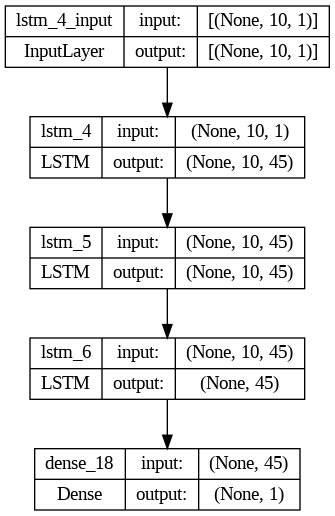

In [ ]:
tf.keras.utils.plot_model( 
    model,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    #rankdir="LR",
    #dpi=96,
)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
%%time
res = model.fit(x_train, y_train, epochs=10, batch_size=320)

Epoch 1/10
7/7 [==============================] - 10s 9ms/step - loss: 0.1201 - mae: 0.2742
Epoch 2/10
7/7 [==============================] - 0s 9ms/step - loss: 0.0242 - mae: 0.1294
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 0.0160 - mae: 0.1104
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.0120 - mae: 0.0868
Epoch 5/10
7/7 [==============================] - 0s 10ms/step - loss: 0.0045 - mae: 0.0590
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0338
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0283
Epoch 8/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0012 - mae: 0.0215
Epoch 9/10
7/7 [==============================] - 0s 10ms/step - loss: 8.7967e-04 - mae: 0.0227
Epoch 10/10
7/7 [==============================] - 0s 8ms/step - loss: 6.7738e-04 - mae: 0.0181
CPU times: user 7.24 s, sys: 697 ms, total: 7.94 s
Wall time: 14.6 s


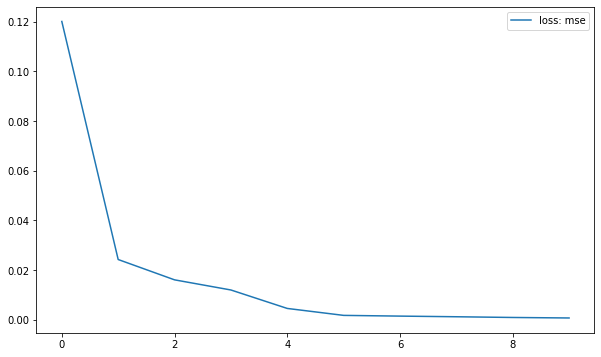

In [ ]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(res.history['loss'], label='loss: mse')
plt.legend()
plt.show()

## Haciendo predicciones

In [ ]:
x_test.shape

(523, 10, 1)

In [ ]:
y_pred = model.predict(x_test)

17/17 [==============================] - 1s 6ms/step


In [ ]:
y_pred.shape

(523, 1)

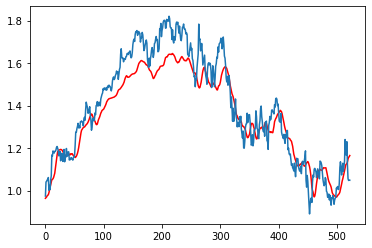

In [ ]:
fig, ax = plt.subplots()

ax.plot(y_pred,c='r')
ax.plot(y_test)

In [ ]:
x_test[0]

array([[0.93103884],
       [0.93980497],
       [0.9359128 ],
       [0.97183485],
       [0.98563392],
       [0.95764157],
       [0.94369724],
       [0.94912429],
       [0.93929345],
       [0.93653498]])

# Reescalando los datos

In [ ]:
y_unscaler = scaler.inverse_transform(y_pred)

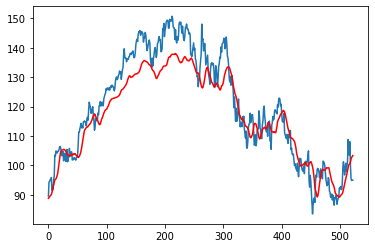

In [ ]:
fig, ax = plt.subplots()

y_real = data.loc[pd.to_datetime('2021-01-01'):,:].to_numpy()

ax.plot(y_real[10:])
ax.plot(y_unscaler, c='r')

In [ ]:
mean_squared_error(y_real[10:],y_unscaler)

44.41621688594993

## Ahora queremos la predicción de dos variables

In [ ]:
df2 = data_raw.copy()
df2

,AAPL,GOOG
Date,,
2013-02-15,14.193984,19.748228
2013-02-19,14.188739,20.095926
2013-02-20,13.845118,19.737518
2013-02-21,13.759058,19.813982
2013-02-22,13.905575,19.918093
...,...,...
2023-02-08,151.688400,100.000000
2023-02-09,150.639999,95.459999
2023-02-10,151.009995,94.860001


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-02-15 to 2023-02-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2517 non-null   float64
 1   GOOG    2517 non-null   float64
dtypes: float64(2)
memory usage: 123.5 KB


In [ ]:
data2 = df2.copy()
data2

,AAPL,GOOG
Date,,
2013-02-15,14.193984,19.748228
2013-02-19,14.188739,20.095926
2013-02-20,13.845118,19.737518
2013-02-21,13.759058,19.813982
2013-02-22,13.905575,19.918093
...,...,...
2023-02-08,151.688400,100.000000
2023-02-09,150.639999,95.459999
2023-02-10,151.009995,94.860001


In [ ]:
data_train2 = data2.loc[:pd.to_datetime('2021-01-01'), :].to_numpy()
data_test2 = data2.loc[pd.to_datetime('2021-01-01'):,:].to_numpy()
print(data_train2.shape)
print(data_test2.shape)

(1984, 2)
(533, 2)


In [ ]:
scaler2 = MinMaxScaler()

data_train2 = scaler2.fit_transform(data_train2)
data_test2 = scaler2.transform(data_test2)
print(data_train2)
print(data_test2)

[[0.01748779 0.00929134]
 [0.01744508 0.0140989 ]
 [0.01464724 0.00914326]
 ...
 [0.985379   0.95211082]
 [0.97614097 0.93883709]
 [0.96786618 0.94738212]]
[[0.94151669 0.93103884]
 [0.9543703  0.93980497]
 [0.91894292 0.9359128 ]
 ...
 [1.13147494 1.04784772]
 [1.15459896 1.04978347]
 [1.14930644 1.04909208]]


In [ ]:
def data_prep2(data):
  x = []
  y = []

  for i in range(10,len(data)):
    x.append(data[i-10:i])
    y.append(data[i])

  x = np.array(x)
  y = np.array(y)

  x = x.reshape(x.shape[0],x.shape[1],2)
  y = y.reshape(y.shape[0],2)
  return x,y

In [ ]:
x_train2, y_train2 = data_prep2(data_train2)
x_train2

array([[[0.01748779, 0.00929134],
        [0.01744508, 0.0140989 ],
        [0.01464724, 0.00914326],
        ...,
        [0.01357231, 0.01166413],
        [0.01277615, 0.01215313],
        [0.01003103, 0.01387159]],

       [[0.01744508, 0.0140989 ],
        [0.01464724, 0.00914326],
        [0.01394652, 0.01020051],
        ...,
        [0.01277615, 0.01215313],
        [0.01003103, 0.01387159],
        [0.00741403, 0.01914405]],

       [[0.01464724, 0.00914326],
        [0.01394652, 0.01020051],
        [0.01513949, 0.01164003],
        ...,
        [0.01003103, 0.01387159],
        [0.00741403, 0.01914405],
        [0.01019929, 0.02503293]],

       ...,

       [[0.88022206, 0.95303724],
        [0.92922576, 0.95836745],
        [0.92866332, 0.95506982],
        ...,
        [0.95396851, 0.933901  ],
        [0.96208216, 0.93837389],
        [1.        , 0.96411941]],

       [[0.92922576, 0.95836745],
        [0.92866332, 0.95506982],
        [0.93581305, 0.94463051],
        .

In [ ]:
x_train2.shape, y_train2.shape

((1974, 10, 2), (1974, 2))

In [ ]:
x_test2, y_test2 = data_prep2(data_test2)
x_test2.shape, y_test2.shape

((523, 10, 2), (523, 2))

## Modelo Recurrente 2

In [ ]:
model2 = Sequential()
#We are gonna change input shape for input_dim
model2.add(LSTM(200, input_shape=(x_train2.shape[1],2),
                   return_sequences=True))
#model2.add(Dropout(0.2))

model2.add(LSTM(128))
model2.add(Dropout(0.1))

model2.add(Dense(32))
#model2.add(Dropout(0.2))

#We are gonna set the number of outputs to 2, to match with the
#number of categories
model2.add(Dense(2))

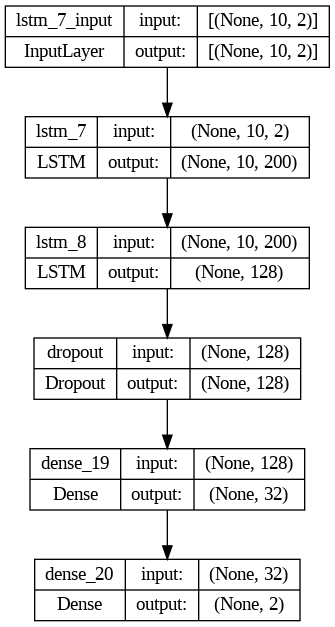

In [ ]:
tf.keras.utils.plot_model( 
    model2,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    #rankdir="LR",
    #dpi=96,
)

In [ ]:
model2.compile(
       loss='mean_squared_error',
       optimizer='adam',
       metrics=['mae'])

In [ ]:
res2 = model2.fit(x_train2, y_train2, epochs=10, batch_size=320)

Epoch 1/10
7/7 [==============================] - 4s 10ms/step - loss: 0.0481 - mae: 0.1559
Epoch 2/10
7/7 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0607
Epoch 3/10
7/7 [==============================] - 0s 9ms/step - loss: 0.0042 - mae: 0.0478
Epoch 4/10
7/7 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0413
Epoch 5/10
7/7 [==============================] - 0s 10ms/step - loss: 0.0021 - mae: 0.0334
Epoch 6/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - mae: 0.0255
Epoch 7/10
7/7 [==============================] - 0s 10ms/step - loss: 0.0011 - mae: 0.0229
Epoch 8/10
7/7 [==============================] - 0s 9ms/step - loss: 8.6623e-04 - mae: 0.0205
Epoch 9/10
7/7 [==============================] - 0s 8ms/step - loss: 8.3894e-04 - mae: 0.0194
Epoch 10/10
7/7 [==============================] - 0s 8ms/step - loss: 7.6872e-04 - mae: 0.0181


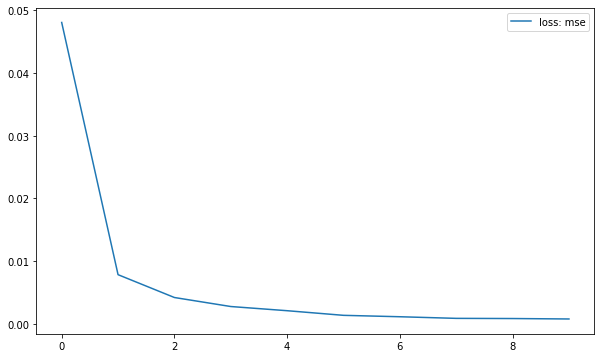

In [ ]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(res2.history['loss'], label='loss: mse')
plt.legend()
plt.show()

## Haciendo predicciones para 2 series

In [ ]:
y_pred2 = model2.predict(x_test2)

17/17 [==============================] - 1s 3ms/step


In [ ]:
y_pred2.shape

(523, 2)

In [ ]:
y_unscaler2 = scaler2.inverse_transform(y_pred2)
y_unscaler2

array([[131.11406 ,  89.12581 ],
       [130.9105  ,  89.20246 ],
       [130.911   ,  89.55947 ],
       ...,
       [153.39314 , 101.89037 ],
       [153.76509 , 101.45223 ],
       [154.3408  , 100.949104]], dtype=float32)

In [ ]:
y_real = data_raw.loc[pd.to_datetime('2021-01-01'):,:].to_numpy()
y_real.shape

(533, 2)

## Predicción para primer entrada del DataFrame

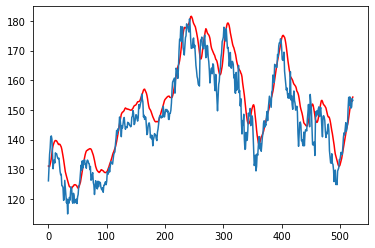

In [ ]:
fig, ax = plt.subplots()

ax.plot(y_unscaler2[:,0],c='r')
ax.plot(y_real[:,0][10:])

## Prediccion para la segunda entrada del DataFrame

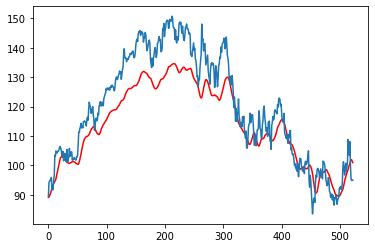

In [ ]:
fig, ax = plt.subplots()

ax.plot(y_unscaler2[:,1],c='r')
ax.plot(y_real[:,1][10:])

# Preguntas

1. ¿Cómo podrían utilizar esto?

2. ¿Que puntos fuertes y que debilidades tiene?

3. ¿Que ventajas y desventajas tendría agregar mas series de tiempo a esto?

4. ¿Qué cambiarían a la hora de pedir los datos de Yahoo para tener mas datos en cada serie de tiempo?